In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import matplotlib.pyplot as plt
from src.evaluation.plot_utils import *
from collections import defaultdict

In [45]:
PLOT_DIR = "../experiments/plots"

BASE_DIR = "/Users/yavuz/scalable-multimodal-similarity-search/experiments/"
CONSTRUCTION_DIR = BASE_DIR + "construction/"
SEARCH_DIR = BASE_DIR + "search/"
EXACT_RESULTS_FOLDER = BASE_DIR + "exact_results/"
SAVED_INDEX_DIR = BASE_DIR + "saved_index/"
STATS_BASE_FOLDER = BASE_DIR + "stats-experiments/"


RERANK_CONSTRUCTION_DIR = BASE_DIR + "rerank_construction/"
RERANK_SEARCH_DIR = BASE_DIR + "rerank_search/"

SEARCH_WEIGHTS_DIR = BASE_DIR + "search_weights_exps/"

FIGURE_DPI = 200

In [47]:
import scienceplots
#plt.style.use([ 'science']) # 'notebook' 'science'

In [106]:
def get_search_weights_data(params, construction_params, base_folder=SEARCH_WEIGHTS_DIR, prev_experiment_folder=1, bracket_split_char="-"):
    folder = base_folder + get_construction_folder(params, bracket_split_char) + get_hnsw_construction_params_folder(construction_params, bracket_split_char)
    index_folder = get_latest_experiment_folder(folder)

    exps_folder = os.path.join(folder, index_folder)
    exp_folder = os.path.join(folder, index_folder, get_latest_experiment_folder(exps_folder, prev_experiment_folder))
    #get the last exp folder - maybe have k in the exp folder name as well, with time-

    search_weights_folders = os.listdir(exp_folder)

    search_weights_data = defaultdict(lambda: defaultdict(list)) # text_weight -> ef -> recall

    for search_weights_folder in search_weights_folders:
        if search_weights_folder.startswith("."):
            continue

        search_weights = search_weights_folder.split(bracket_split_char)[1]
        text_weight = float(search_weights.split(",")[0])

        for ef_folder in os.listdir(exp_folder + "/" + search_weights_folder):
            if ef_folder.startswith("."):
                continue
            stats = ef_folder.split("_")
            k = int(stats[0])
            ef = int(stats[1])

            if ef >=k:
                # load results.npz file
                results = np.load(os.path.join(exp_folder, search_weights_folder, ef_folder, "results.npz"))
                # results contains recall_scores, ef_search
                assert ef == results["ef_search"]
                search_weights_data[text_weight][ef].append(results["recall_scores"])

    print(f"Read values for k={k} for dataset size {params.index_size} for {len(search_weights_data[text_weight])} ef values")
    return search_weights_data, k

In [119]:
def plot_heatmap_for_search_weights_data(params, construction_params, search_weights_data, max_ef=float('inf'), plots_dir=PLOT_DIR):
    # search_weights_data is weights -> ef -> list of recall for 100 queries
    # we have 11 values for weights: 0.0 to 1.0, and around 15 for ef
    # for each cell combination, we plot a heatmap of the average of the recall values

    # we plot image weights, so first transform to 1-text_weight
    transformed_data = {}
    for weight, ef_dict in search_weights_data.items():
        new_weight = round(1.0 - weight, 5)
        transformed_data[new_weight] = ef_dict
    weights = sorted(transformed_data.keys())
    efs = sorted({ef for ef_dict in transformed_data.values() for ef in ef_dict if ef <= max_ef})

    heatmap_data = np.zeros((len(weights), len(efs)))

    for i, weight in enumerate(weights):
        for j, ef in enumerate(efs):
            recall_list = transformed_data[weight][ef]
            assert len(recall_list) > 0, f"Missing data for weight {weight} and ef {ef}"
            heatmap_data[i, j] = np.mean(recall_list)

    plt.figure(figsize=(10, 6))
    im = plt.imshow(heatmap_data, aspect='auto', origin='lower', cmap='viridis', vmax=1) #viridis, YlGn, summer

    plt.xticks(ticks=np.arange(len(efs)), labels=efs)
    plt.yticks(ticks=np.arange(len(weights)), labels=[f"{w:.1f}" for w in weights])

    plt.xlabel("efSearch")
    plt.ylabel("Image Search Weight (1 - Text Search Weight)")
    plt.title(f"Recall Heatmap on MultiVecHNSW with Index Weights [{round(params.weights[0], 5)}, {round(params.weights[1], 5)}]")

    plt.colorbar(im, label="Average Recall")

    plt.tight_layout()

    # save plot
    if not os.path.exists(f"{plots_dir}/search_weights"):
        os.makedirs(f"{plots_dir}/search_weights")
    print(params.weights[0],int(params.weights[0]*100))
    plt.savefig(f"{plots_dir}/search_weights/recall_heatmap_{params.index_size}_weight_{int(params.weights[0]*100)}_ef{construction_params.ef_construction}_seed_{construction_params.seed}_k{params.k}", dpi=FIGURE_DPI, bbox_inches='tight')

    plt.show()

In [120]:
search_weights_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=100_000)
search_weights_construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=3)

prev_experiment_folder = 1
search_weights_data, k = get_search_weights_data(search_weights_exp_params, search_weights_construction_params, prev_experiment_folder=prev_experiment_folder, bracket_split_char=":")
search_weights_exp_params.k = k

Read values for k=50 for dataset size 100000 for 26 ef values


0.5 50


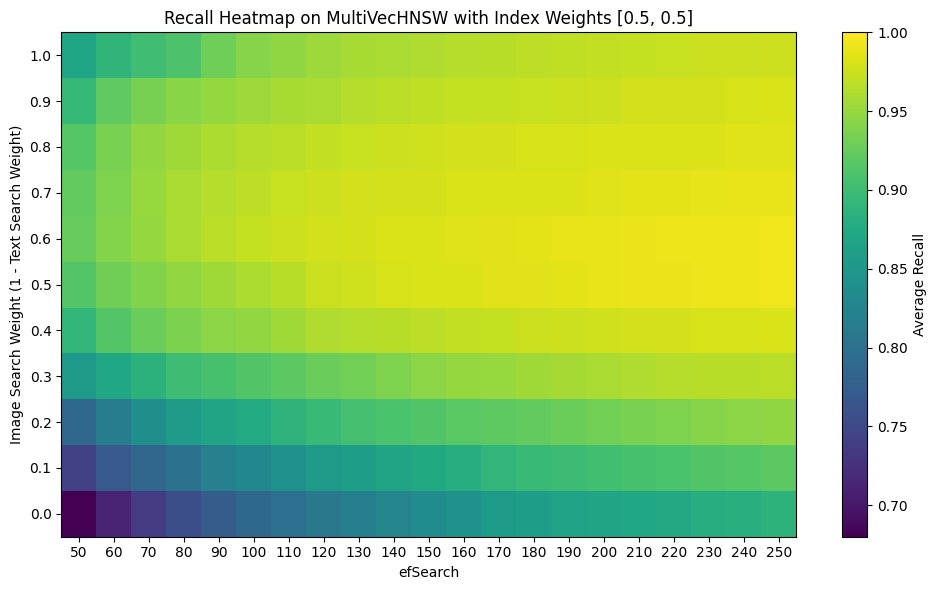

In [121]:
plot_heatmap_for_search_weights_data(search_weights_exp_params, search_weights_construction_params, search_weights_data, max_ef=250)

In [122]:
search_weights_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=1_000_000)
search_weights_construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=3)

prev_experiment_folder = 1
search_weights_data, k = get_search_weights_data(search_weights_exp_params, search_weights_construction_params, prev_experiment_folder=prev_experiment_folder, bracket_split_char=":")
search_weights_exp_params.k = k

Read values for k=50 for dataset size 1000000 for 36 ef values


0.5 50


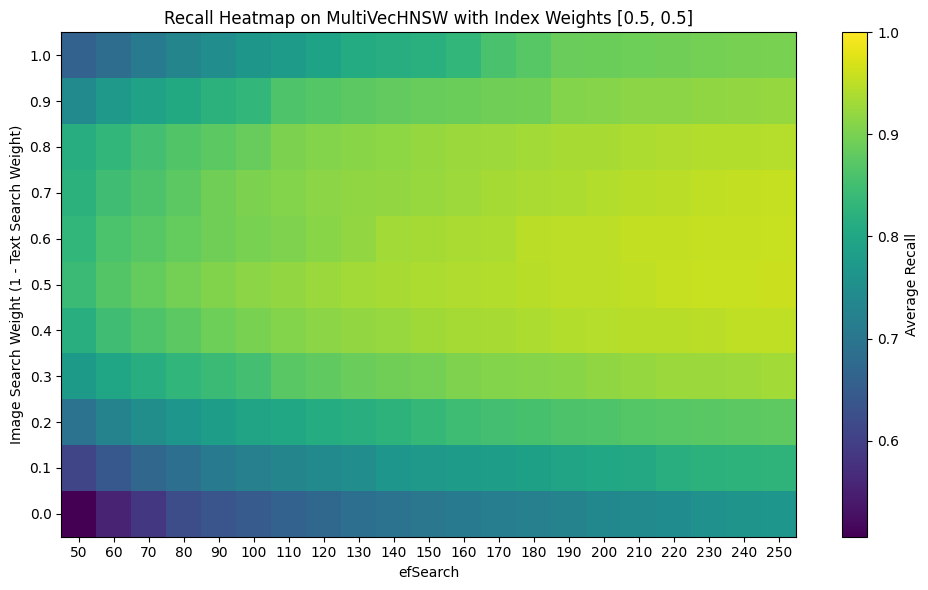

In [123]:
plot_heatmap_for_search_weights_data(search_weights_exp_params, search_weights_construction_params, search_weights_data, max_ef=250)

In [124]:
stats_search_exps_folder = STATS_BASE_FOLDER + "search_weights_exps/"

In [ ]:
for text_weight in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    search_weights_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[text_weight, round(1-text_weight, 5)], index_size=1_000_000)
    search_weights_construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=60)

    prev_experiment_folder = 1
    search_weights_data, k = get_search_weights_data(search_weights_exp_params, search_weights_construction_params, base_folder=stats_search_exps_folder, prev_experiment_folder=prev_experiment_folder)
    search_weights_exp_params.k = k

    plot_heatmap_for_search_weights_data(search_weights_exp_params, search_weights_construction_params, search_weights_data, max_ef=250)

In [144]:
def get_construction_stats(params, construction_params, base_folder=STATS_BASE_FOLDER, bracket_split_char="-"):
    folder = base_folder + "construction/" + get_construction_folder(params, bracket_split_char) + get_hnsw_construction_params_folder(construction_params, bracket_split_char)
    data_file = get_latest_experiment_folder(folder)

    # load data file .npz
    data = np.load(os.path.join(folder, data_file))
    return data


In [411]:
def plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_dir=PLOT_DIR):
    # plot the distance calls for each text weight
    fig, ax = plt.subplots(figsize=(10, 6))
    x_val = list(times.keys())
    assert len(x_val) == len(total_distance_calls), f"Length mismatch: {len(x_val)} vs {len(total_distance_calls)}"
    assert len(x_val) == len(num_lazy_distance_cutoffs), f"Length mismatch: {len(x_val)} vs {len(num_lazy_distance_cutoffs)}"


    # plot times on the same plot but on the right y-axis
    ax1 = ax
    ax1.plot(times.keys(), times.values(), label="Construction Time", color='red', marker='s', zorder=20)
    ax1.set_ylim(400, 1500)
    ax1.set_ylabel("Construction Time (s)", color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.set_xlabel("Index Text Weight (1- Image Weight)")

    ax2 = ax.twinx()
    ax2.plot(total_distance_calls.keys(), total_distance_calls.values(), label="Total Distance Computations", marker='o', zorder=30)
    ax2.plot(num_lazy_distance_cutoffs.keys(), num_lazy_distance_cutoffs.values(), label="Total Distance Computations Cutoff", marker='o', zorder=29)
    ax2.set_ylabel("Number of Distance Computations")

    # plot ax on top of ax2
    ax1.set_zorder(11)
    ax2.set_zorder(12)
    ax1.patch.set_visible(False)

    ax1.yaxis.tick_right()
    ax1.yaxis.set_label_position("right")

    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")

    ax.set_title(f"Index Construction Stats for Varying Index Weights with Metrics [{params.metrics[0]}, {params.metrics[1]}]")

    # combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines += lines2
    labels += labels2
    ax2.legend(lines, labels, loc="upper left")


    ax2.grid()
    ax1.grid(axis="x")

    # save plot
    if not os.path.exists(f"{plot_dir}/weights-construction"):
        os.makedirs(f"{plot_dir}/weights-construction")
    plt.savefig(f"{plot_dir}/weights-construction/distance_calls_{params.index_size}_{params.metrics[0]}-{params.metrics[1]}_seed_{construction_params.seed}", dpi=FIGURE_DPI, bbox_inches='tight')
    plt.show()

In [418]:
times = {}
num_compute_distance_calls = {}
num_lazy_distance_calls = {}
total_distance_calls = {}
num_lazy_distance_cutoffs = {}  # = num_vectors_skipped_due_to_cutoff, since modality is 1
for text_weight in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

    params = Params(modalities=2, dimensions=[384, 768], metrics=["manhattan", "manhattan"], weights=[text_weight, round(1-text_weight, 5)], index_size=1_000_000)
    construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=60)

    data = get_construction_stats(params, construction_params)
    times[text_weight] = data["time"]
    num_compute_distance_calls[text_weight] = data["num_compute_distance_calls"]
    num_lazy_distance_calls[text_weight] = data["num_lazy_distance_calls"]
    num_lazy_distance_cutoffs[text_weight] = data["num_vectors_skipped_due_to_cutoff"]
    total_distance_calls[text_weight] = num_compute_distance_calls[text_weight] + num_lazy_distance_calls[text_weight]

# for weights 0.0 and 1.0, every distance call is cutoff, but these aren't captured in the stats above so we manually set them
num_lazy_distance_cutoffs[1.0] = total_distance_calls[1.0]
num_lazy_distance_cutoffs[0.0] = total_distance_calls[0.0]

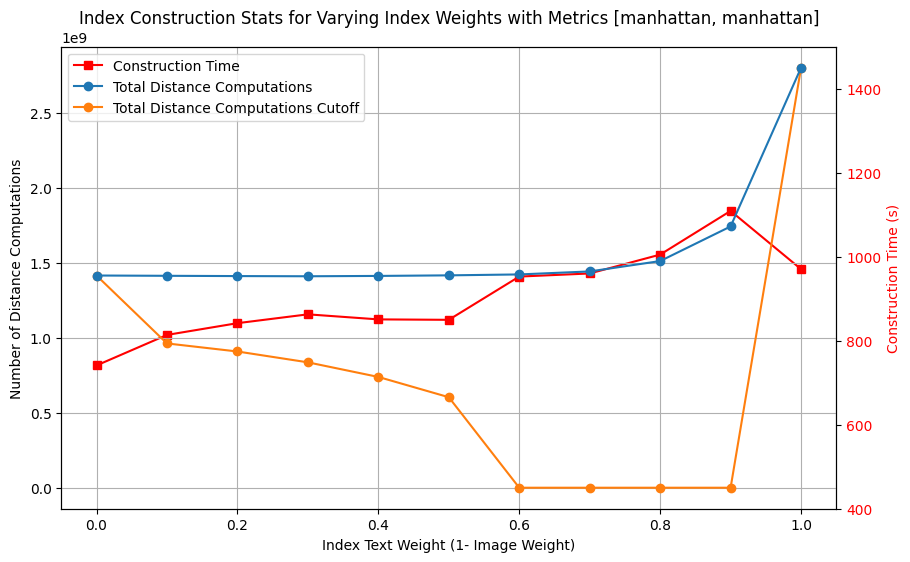

In [419]:
plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs)